Current notebook adapted from the notebook https://github.com/sequenceanalysis/sequenceanalysis.github.io/blob/master/notebooks/part2.ipynb

# Preliminaries

In [93]:
import copy
import itertools
from collections import defaultdict
from operator import itemgetter

In [94]:
from tqdm.notebook import tqdm #loading-bar library

#### Our dataset format
An event is a list of strings.

A sequence is a list of events.

A dataset is a list of sequences.

Thus, a dataset is a list of lists of lists of strings.

In [95]:
dataset =  [
    [["a"], ["a", "b", "c"], ["a", "c"], ["c"]],
    [["a"], ["c"], ["b", "c"]],
    [["a", "b"], ["d"], ["c"], ["b"], ["c"]],
    [["a"], ["c"], ["b"], ["c"]]
]

# Foundations
### Subsequences

In [96]:
"""
This is a simple recursive method that checks if subSequence is a subsequence of mainSequence
"""
def isSubsequence(mainSequence, subSequence):
    subSequenceClone = list(subSequence) # clone the sequence, because we will alter it
    return isSubsequenceRecursive(mainSequence, subSequenceClone) #start recursion

"""
Function for the recursive call of isSubsequence, not intended for external calls
"""
def isSubsequenceRecursive(mainSequence, subSequenceClone, start=0):
    # Check if empty: End of recursion, all itemsets have been found
    if (not subSequenceClone):
        return True
    # retrieves element of the subsequence and removes is from subsequence 
    firstElem = set(subSequenceClone.pop(0))
    # Search for the first itemset...
    for i in range(start, len(mainSequence)):
        if (set(mainSequence[i]).issuperset(firstElem)):
            # and recurse
            return isSubsequenceRecursive(mainSequence, subSequenceClone, i + 1)
    return False

In [97]:
aSequence = [["a"], ["b", "c"], ["d"], ["a", "e"]]

In [98]:
isSubsequence(aSequence, [["a"], ["d"], ["e"]])

True

In [99]:
isSubsequence(aSequence, [["a"], ["b", "c"], ["e"]])

True

In [100]:
isSubsequence(aSequence, [["a"], ["b", "d"]])

False

### Length of an itemset

In [101]:
"""
Computes the length of the sequence (sum of the length of the contained itemsets)
"""
def sequenceLength(sequence):
    return sum(len(i) for i in sequence)

In [102]:
print(sequenceLength([["a"], ["b", "c"], ["a"], ["b","c","d"]]))

7


### Support of a sequence

In [103]:
"""
Computes the support of a sequence in a dataset
"""
def countSupport (dataset, candidateSequence):
    return sum(1 for seq in dataset if isSubsequence(seq, candidateSequence)) 

In [104]:
dataset

[[['a'], ['a', 'b', 'c'], ['a', 'c'], ['c']],
 [['a'], ['c'], ['b', 'c']],
 [['a', 'b'], ['d'], ['c'], ['b'], ['c']],
 [['a'], ['c'], ['b'], ['c']]]

In [105]:
countSupport(dataset, [["b"]])

4

In [106]:
countSupport(dataset, [["a"], ["b", "c"]])

2

# AprioriAll
### 1 . Candidate Generation
#### For a single pair:

In [107]:
"""
Generates one candidate of length k from two candidates of length (k-1) as used in the AprioriAll algorithm
"""
def generateCandidatesForPair(cand1, cand2):
    cand1Clone = copy.deepcopy(cand1)
    cand2Clone = copy.deepcopy(cand2)
    # drop the leftmost item from cand1:
    if (len (cand1[0]) == 1):
        cand1Clone.pop(0)
    else:
        cand1Clone[0] = cand1Clone[0][1:]
    # drop the rightmost item from cand2:
    if (len (cand2[-1]) == 1):
        cand2Clone.pop(-1)
    else:
        cand2Clone[-1] = cand2Clone[-1][:-1]
    
    # if the result is not the same, then we dont need to join
    if not cand1Clone == cand2Clone:
        return []
    else:
        newCandidate = copy.deepcopy(cand1)
        if (len (cand2[-1]) == 1):
            newCandidate.append(cand2[-1])
        else:
            newCandidate [-1].extend(cand2[-1][-1])
        return newCandidate

In [108]:
candidateA = [["a"], ["b", "c"], ["d"]]
candidateB = [["b", "c"], ["d", "e"]]
generateCandidatesForPair(candidateA, candidateB)

[['a'], ['b', 'c'], ['d', 'e']]

In [109]:
candidateA = [["a"], ["b", "c"], ["d"]]
candidateC = [["b", "c"], ["d"], ["e"]]
generateCandidatesForPair(candidateA, candidateC)

[['a'], ['b', 'c'], ['d'], ['e']]

In [110]:
candidateA = [["a"], ["b", "c"], ["d"]]
candidateD = [["a"], ["b", "c"], ["e"]]
generateCandidatesForPair(candidateA, candidateD)

[]

#### For a set of candidates (of the last level):

In [111]:
"""
Generates the set of candidates of length k from the set of frequent sequences with length (k-1)
"""
def generateCandidates(lastLevelCandidates):
    k = sequenceLength(lastLevelCandidates[0]) + 1
    if (k == 2):
        flatShortCandidates = [item for sublist2 in lastLevelCandidates for sublist1 in sublist2 for item in sublist1]
        result = [[[a, b]] for a in flatShortCandidates for b in flatShortCandidates if b > a]
        result.extend([[[a], [b]] for a in flatShortCandidates for b in flatShortCandidates])
        return result
    else:
        candidates = []
        for i in range(0, len(lastLevelCandidates)):
            for j in range(0, len(lastLevelCandidates)):
                newCand = generateCandidatesForPair(lastLevelCandidates[i], lastLevelCandidates[j])
                if (not newCand == []):
                    candidates.append(newCand)
        candidates.sort()
        return candidates

An example; Lets assume, we know the frequent sequences of level 2:

In [112]:
lastLevelFrequentPatterns = [
    [['a', 'b']], 
    [['b', 'c']], 
    [['a'], ['b']], 
    [['a'], ['c']], 
    [['b'], ['c']],
    [['c'], ['b']], 
    [['c'], ['c']],  
]

Then we can compute the generate candidates for level 3

In [113]:
newCandidates = generateCandidates(lastLevelFrequentPatterns)
newCandidates

[[['a'], ['b'], ['c']],
 [['a'], ['b', 'c']],
 [['a'], ['c'], ['b']],
 [['a'], ['c'], ['c']],
 [['a', 'b'], ['c']],
 [['a', 'b', 'c']],
 [['b'], ['c'], ['b']],
 [['b'], ['c'], ['c']],
 [['b', 'c'], ['b']],
 [['b', 'c'], ['c']],
 [['c'], ['b'], ['c']],
 [['c'], ['b', 'c']],
 [['c'], ['c'], ['b']],
 [['c'], ['c'], ['c']]]

### 2 . Candidate Checking

In [114]:
"""
Computes all direct subsequence for a given sequence.
A direct subsequence is any sequence that originates from deleting exactly one item from any event in the original sequence.
"""
def generateDirectSubsequences(sequence):
    result = []
    for i, itemset in enumerate(sequence):
        if (len(itemset) == 1):
            sequenceClone = copy.deepcopy(sequence)
            sequenceClone.pop(i)
            result.append(sequenceClone)
        else:
            for j in range(len(itemset)):
                sequenceClone = copy.deepcopy(sequence)
                sequenceClone[i].pop(j)
                result.append(sequenceClone)
    return result

In [115]:
"""
Prunes the set of candidates generated for length k given all frequent sequence of level (k-1), as done in AprioriAll
"""
def pruneCandidates(candidatesLastLevel, candidatesGenerated):
    return [cand for cand in candidatesGenerated if all(x in candidatesLastLevel for x in generateDirectSubsequences(cand))]

We apply this on example dataset

In [116]:
candidatesPruned = pruneCandidates(lastLevelFrequentPatterns, newCandidates)
candidatesPruned

[[['a'], ['b'], ['c']],
 [['a'], ['b', 'c']],
 [['a'], ['c'], ['b']],
 [['a'], ['c'], ['c']],
 [['a', 'b'], ['c']],
 [['b'], ['c'], ['c']],
 [['b', 'c'], ['c']],
 [['c'], ['b'], ['c']],
 [['c'], ['b', 'c']],
 [['c'], ['c'], ['b']],
 [['c'], ['c'], ['c']]]

### 3. Count Candidates (and filter not frequent ones):

In [117]:
minSupport = 2
candidatesCounts = [(i, countSupport(dataset, i)) for i in candidatesPruned]
resultLvl = [(i, count) for (i, count) in candidatesCounts if (count >= minSupport)]
resultLvl

[([['a'], ['b'], ['c']], 3),
 ([['a'], ['b', 'c']], 2),
 ([['a'], ['c'], ['b']], 3),
 ([['a'], ['c'], ['c']], 4),
 ([['a', 'b'], ['c']], 2),
 ([['b'], ['c'], ['c']], 2),
 ([['c'], ['b'], ['c']], 2)]

### Put it all together:

In [118]:
"""
The AprioriAll algorithm. Computes the frequent sequences in a seqeunce dataset for a given minSupport

Args:
    dataset: A list of sequences, for which the frequent (sub-)sequences are computed
    minSupport: The minimum support that makes a sequence frequent
    verbose: If true, additional information on the mining process is printed (i.e., candidates on each level)
Returns:
    A list of tuples (s, c), where s is a frequent sequence, and c is the count for that sequence
"""
def apriori(dataset, minSupport, verbose=False):
    global numberOfCountingOperations
    numberOfCountingOperations = 0
    Overall = []
    itemsInDataset = sorted(set ([item for sublist1 in dataset for sublist2 in sublist1 for item in sublist2]))
    singleItemSequences = [[[item]] for item in itemsInDataset]
    singleItemCounts = [(i, countSupport(dataset, i)) for i in singleItemSequences if countSupport(dataset, i) >= minSupport]
    Overall.append(singleItemCounts)
    print("Result, lvl 1: " + str(Overall[0]))
    k = 1
    while (True):
        if not Overall [k - 1]:
            break
        # 1. Candidate generation
        candidatesLastLevel = [x[0] for x in Overall[k - 1]]
        candidatesGenerated = generateCandidates (candidatesLastLevel)
        # 2. Candidate pruning (using a "containsall" subsequences)
        candidatesPruned = [cand for cand in candidatesGenerated if all(x in candidatesLastLevel for x in generateDirectSubsequences(cand))]
        # 3. Candidate checking
        candidatesCounts = [(i, countSupport(dataset, i)) for i in candidatesPruned]
        resultLvl = [(i, count) for (i, count) in candidatesCounts if (count >= minSupport)]
        if verbose:
            print("Candidates generated, lvl " + str(k + 1) + ": " + str(candidatesGenerated))
            print("Candidates pruned, lvl " + str(k + 1) + ": " + str(candidatesPruned))
            print("Result, lvl " + str(k + 1) + ": " + str(resultLvl))
        Overall.append(resultLvl)
        k = k + 1
    # "flatten" Overall
    Overall = Overall [:-1]
    Overall = [item for sublist in Overall for item in sublist]
    return Overall

In [119]:
apriori(dataset, 2, verbose=False)

Result, lvl 1: [([['a']], 4), ([['b']], 4), ([['c']], 4)]


[([['a']], 4),
 ([['b']], 4),
 ([['c']], 4),
 ([['a', 'b']], 2),
 ([['b', 'c']], 2),
 ([['a'], ['b']], 4),
 ([['a'], ['c']], 4),
 ([['b'], ['c']], 3),
 ([['c'], ['b']], 3),
 ([['c'], ['c']], 4),
 ([['a'], ['b'], ['c']], 3),
 ([['a'], ['b', 'c']], 2),
 ([['a'], ['c'], ['b']], 3),
 ([['a'], ['c'], ['c']], 4),
 ([['a', 'b'], ['c']], 2),
 ([['b'], ['c'], ['c']], 2),
 ([['c'], ['b'], ['c']], 2),
 ([['a'], ['c'], ['b'], ['c']], 2),
 ([['a', 'b'], ['c'], ['c']], 2)]

# PrefixSpan



## Project a sequence

In [120]:
"""
Projects a sequence according to a given prefix, as done in PrefixSpan

Args:
    sequence: the sequence the projection is built from
    prefix: the prefix that is searched for in the sequence
    newEvent: if set to True, the first itemset is ignored
Returns:
    If the sequence does not contain the prefix, then None.
    Otherwise, a new sequence starting from the position of the prefix, including the itemset that includes the prefix
"""
def projectSequence(sequence, prefix, newEvent):
    result = None
    for i, itemset in enumerate(sequence):
        if result is None:
            if (not newEvent) or i > 0:
                if (all(x in itemset for x in prefix)):
                    result = [list(itemset)]
        else:
            result.append(copy.copy(itemset))
    return result

In [121]:
seq = [["a"], ["b", "c"], ["a", "c"], ["c"]]
projectSequence(seq, ["b"], False)

[['b', 'c'], ['a', 'c'], ['c']]

In [122]:
projectSequence(seq, ["a", "c"], False)

[['a', 'c'], ['c']]

In [123]:
projectSequence(seq, ["a"], False)

[['a'], ['b', 'c'], ['a', 'c'], ['c']]

In [124]:
projectSequence(seq, ["a"], True)

[['a', 'c'], ['c']]

## Project a dataset

In [125]:
"""
Projects a dataset according to a given prefix, as done in PrefixSpan

Args:
    dataset: the dataset the projection is built from
    prefix: the prefix that is searched for in the sequence
    newEvent: if set to True, the first itemset is ignored
Returns:
    A (potentially empty) list of sequences
"""
def projectDatabase(dataset, prefix, newEvent):
    projectedDB = []
    for sequence in dataset:
        seqProjected = projectSequence(sequence, prefix, newEvent)
        if not seqProjected is None:
            projectedDB.append(seqProjected)
    return projectedDB

In [126]:
datasetProject = [
            [["a"], ["a", "b", "c"], ["a", "c"], ["d"], ["c", "f"]],
            [["a", "d"], ["c"], ["b", "c"], ["a", "e"]],
            [["e", "f"], ["a", "b"], ["d", "f"], ["d"], ["b"]],
            [["e"], ["g"], ["a", "f"], ["c"], ["b"], ["c"]]
        ]

In [127]:
projectDatabase(datasetProject, ["c"], False)

[[['a', 'b', 'c'], ['a', 'c'], ['d'], ['c', 'f']],
 [['c'], ['b', 'c'], ['a', 'e']],
 [['c'], ['b'], ['c']]]

## The main algorithm

#### Some more utility functions:

In [128]:
"""
Generates a list of all items that are contained in a dataset
"""
def generateItems(dataset):
    return sorted(set ([item for sublist1 in dataset for sublist2 in sublist1 for item in sublist2]))

"""
Computes a defaultdict that maps each item in the dataset to its support
"""
def generateItemSupports(dataset, ignoreFirstEvent=False, prefix=[]):
    result = defaultdict(int)
    for sequence in dataset:
        if ignoreFirstEvent:
            sequence = sequence[1:]
        cooccurringItems = set()
        for itemset in sequence:
            if all(x in itemset for x in prefix):
                for item in itemset:
                    if not item in prefix:
                        cooccurringItems.add(item)
        for item in cooccurringItems:
            result [item] += 1
    return sorted(result.items())

#### Finally, the algorithm:

In [129]:
"""
The PrefixSpan algorithm. Computes the frequent sequences in a sequence dataset for a given minSupport

Args:
    dataset: A list of sequences, for which the frequent (sub-)sequences are computed
    minSupport: The minimum support that makes a sequence frequent
Returns:
    A list of tuples (s, c), where s is a frequent sequence, and c is the count for that sequence
"""
def prefixSpan(dataset, minSupport):
    result = []
    itemCounts = generateItemSupports(dataset)
    for item, count in tqdm(itemCounts):
        if count >= minSupport:
            newPrefix = [[item]]
            result.append((newPrefix, count))
            result.extend(prefixSpanInternal(projectDatabase(dataset, [item], False), minSupport, newPrefix))
    return result

def prefixSpanInternal(dataset, minSupport, prevPrefixes=[]):
    result = []
    
    # Add a new item to the last element (==same time)
    itemCountSameEvent = generateItemSupports(dataset, False, prefix=prevPrefixes[-1])
    for item, count in itemCountSameEvent:
        if (count >= minSupport) and item > prevPrefixes[-1][-1]:
            newPrefix = copy.deepcopy(prevPrefixes)
            newPrefix[-1].append(item)
            result.append((newPrefix, count))
            result.extend(prefixSpanInternal(projectDatabase(dataset, newPrefix[-1], False), minSupport, newPrefix))
        
    # Add a new event to the prefix
    itemCountSubsequentEvents = generateItemSupports(dataset, True)
    for item, count in itemCountSubsequentEvents:
        if count >= minSupport:
            newPrefix = copy.deepcopy(prevPrefixes)
            newPrefix.append([item])
            result.append((newPrefix, count))
            result.extend(prefixSpanInternal(projectDatabase(dataset, [item], True), minSupport, newPrefix))
    return result

In [130]:
prefixSpan(dataset, 2)

[([['a']], 4),
 ([['a', 'b']], 2),
 ([['a', 'b'], ['c']], 2),
 ([['a', 'b'], ['c'], ['c']], 2),
 ([['a'], ['b']], 4),
 ([['a'], ['b', 'c']], 2),
 ([['a'], ['b'], ['c']], 3),
 ([['a'], ['c']], 4),
 ([['a'], ['c'], ['b']], 3),
 ([['a'], ['c'], ['b'], ['c']], 2),
 ([['a'], ['c'], ['c']], 4),
 ([['b']], 4),
 ([['b', 'c']], 2),
 ([['b'], ['c']], 3),
 ([['b'], ['c'], ['c']], 2),
 ([['c']], 4),
 ([['c'], ['b']], 3),
 ([['c'], ['b'], ['c']], 2),
 ([['c'], ['c']], 4)]

# Filter for closed and maximal patterns
### Closed patterns

In [131]:
"""
Given a list of all frequent sequences and their counts, compute the set of closed frequent sequences (as a list)
This is only a very simplistic (naive) implementation for demonstration purposes!
"""
def filterClosed(result):
    for supersequence, countSeq in tqdm(copy.deepcopy(result)):
        for subsequence, countSubSeq in copy.deepcopy(result):
            if isSubsequence(supersequence, subsequence) and (countSeq == countSubSeq) and subsequence != supersequence:
                result.remove((subsequence, countSubSeq))

In [132]:
result = prefixSpan(dataset, 2)
filterClosed(result)
result

[([['a', 'b'], ['c'], ['c']], 2),
 ([['a'], ['b']], 4),
 ([['a'], ['b', 'c']], 2),
 ([['a'], ['b'], ['c']], 3),
 ([['a'], ['c'], ['b']], 3),
 ([['a'], ['c'], ['b'], ['c']], 2),
 ([['a'], ['c'], ['c']], 4)]

### Maximal sequences

In [133]:
"""
Given a list of all frequent sequences and their counts, compute the set of maximal frequent sequences (as a list)
This is only a very naive implementation for demonstration purposes!
"""
def filterMaximal(result):
    for supersequence, countSeq in tqdm(copy.deepcopy(result)):
        for subsequence, countSubSeq in copy.deepcopy(result):
            if isSubsequence (supersequence, subsequence) and subsequence != supersequence:
                result.remove((subsequence, countSubSeq)) 

In [134]:
result = prefixSpan (dataset, 2)
filterMaximal(result)
result

[([['a', 'b'], ['c'], ['c']], 2),
 ([['a'], ['b', 'c']], 2),
 ([['a'], ['c'], ['b'], ['c']], 2)]

# Assignment 2 example: extracting emerging patterns from movie reviews


We want to extract emerging patterns from positive and negative movie reviews. The goal will be to find some patterns that are characteristic of positive reviews and some patterns that are characteristic of negative review.


## Step 1 : data and library imports

In [135]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pandas as pd

In [136]:
pd.set_option('display.max_colwidth', -1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


In [137]:
path = '/content/drive/MyDrive/nantes/tspm/assignment2'

In [138]:
#given lines
readme_df = pd.read_csv(path+'/readme.csv', sep=';')
readme_df[readme_df['#Last_name'] == 'Paulet']

,#Last_name,First_name,neg_files,pos_files
8,Paulet,Louis,2400_x.txt —> 9900_y.txt,300_x.txt —> 7800_y.txt


We rely on the following notebook (made by myself) for converting all these text files into one csv which is easy and fast to import into a dataframe :  

https://colab.research.google.com/drive/1VVzWqhpZbS_FvJk6yAUlag-C9E0u7gIJ?usp=sharing



In [139]:
train_neg_df = pd.read_csv(path+'/neg/export.csv')
train_neg_df.drop('Unnamed: 0', inplace=True, axis=1)
train_neg_df

,filename,content
0,2400_3,"No, this wasn't one of the ten worst films of the 1980's, but it certainly skirts the bottom 100 somewhere. This movie looks like it was put on the shelf for two or three years and then released in 1981. How else would you explain special effects pre-dating ""An American Werewolf in London,"" disco still being considered cool, and Ronald Reagan not being the 40th President of the United States? While we're at it, let's not overlook those 1970's hairstyles in the 1950's and '60's. I've seen more of that here than in ""Happy Days"" & ""Laverne & Shirley"" combined.<br /><br />The one woman who elevates this movie to the ""so bad, it's good"" category was the late, great Elizabeth Hartman, but just barely. Biff plays as Miss Montgomery, the mousey high school teacher who becomes a sexpot, a stereotype that's been done to death and is still being churned out by Hollywood today, but even as a ""hot chick"" she retains her mousey qualities. Her call for help is evidence of this. She also looks much better as Miss Wimp. ""Seven bucks at the beauty parlor, shot to hell."" She wasn't kidding.<br /><br />This isn't to say that there aren't any good parts elsewhere, they're just few and far between, and I'm not just saying that because I like Hartman. Incidentally, ""Teen Wolf"" was better than this. ""Teen Wolf Too"" was better than this, and that wasn't even so good.<br /><br />"
1,2401_3,"I've seen better teenage werewolf movies in my time, this one however, takes the cake. More comedy than horror, ""Full Moon High"" puts the ""c"" in cheese-fest. The star quality in this movie is not bad. Just the way it was made just sends in rolling downhill. Adam Arkin plays Tony, an all-American high school football player of the 50's who ends up not aging due to a werewolf bite in Transylvania. The most annoying part of the movie was the violin player. He drove everyone batty! Ed McMahon plays his ultra-conservative father who met his end of his own bullet. Adam's father Alan plays a shrink who seems to be not top of his game. After all these years Tony seems to be very out of place due to the attack, and then he'll get the chance to catch in his state. More laugh than blood shed, this movie is just a start in the 80's, ""Teen Wolf"" was an improvement from this! 1 out of 5 stars."
2,2402_3,"A surprising misfire from the usually reliable Larry Cohen (God Told Me Too, Q, etc.), Full Moon High tries so hard to be funny and fails miserably, even with decent turns by Ed McMahon(!) and Kenneth Mars. Alan Arkin looks embarrassed throughout his performance and son Adam simply looks numb. This makes Teen Wolf look like a comedy classic."
3,2403_1,Whack!!! I got this movie because Elizabeth Hartman was in it. I was disappointed to find out she was in like two short scenes towards the end. Other than that I was basically hitting the fast forward button the entire time. Some teenager goes on a trip to Romania with his Dad and gets bitten by a wolf and turns into a werewolf if there's a full moon. He kills his father and friends. About 30 years past but he doesn't age a bit and enrolls in a high school. There he meets a shy teacher whom he ends up biting and then has kids with her. This movie sucked and I don't recommend it to anyone. Read War and Peace instead. Only Ms. Hartman did a great job. Check out a very young Bob Saget in this one!!
4,2404_3,"Man, was I disappointed.<br /><br />1) Adam Arkin is more whiny than Ross Geller from 'Friends' <br /><br />2) A great cast is wasted (Kenneth Mars, Alan Arkin, Ed McMahon, Pat Morita, Louis Nye) with this amateurish script.<br /><br />3) The movie suffers from horrible pacing. It jumps around through in a jumbled, confusing manner.<br /><br />4) The story doesn't even make sense. Why does he want to break the football streak? What about the stupid violin music? None of it is explained.<br /><br />5) It's not even funny. It's like a bunch of accountants trying to do improv, saying "

In [140]:
train_pos_df = pd.read_csv(path+'/pos/export.csv')
train_pos_df.drop('Unnamed: 0', inplace=True, axis=1)
train_pos_df

filename                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

## Step 2 : Itemset creation (sentence per sentence)

Convert the sentences of the positive review files assigned to you into itemset sequences, using inflected forms, lemmas, and POS tags to create the itemsets of each word. You can use spaCy or nltk for the tokenization, the lemmatization, and the POS tagging.
Your positive review dataset, posDataset, should follow the format described at the beginning of the notebook. 

Import staCy and load the english dataset. We also load the "os" library to acces all files in a given folder.

In [141]:
import spacy
import os
nlp = spacy.load('en_core_web_sm')

First function : sentence to itemset of lemmas and POS

In [142]:
def sentence_to_itemsets(sentence):

  doc = nlp(sentence)
  output_list = []
  for token in doc:
      #some filtering to get rid of punctuation
      if (token.pos_ != 'PUNCT'):
        #then we get rid of determinants since they are frequent and don't indicate a positive or negative bias
        if (token.pos_ != 'DET'):
          if (token.pos_ != 'CCONJ'):
            if (token.pos_ != 'ADP'):
              output_list.append((token.orth_,token.lemma_, token.pos_)) #we create a tuple to contain all properties of the token as a single item (which is hashable for prefix span)
      
  return output_list

sentence = 'Once again Mr. Costner has dragged out a movie for far longer than necessary.'

#test
sentence_to_itemsets(sentence)

[('Once', 'once', 'ADV'),
 ('again', 'again', 'ADV'),
 ('Mr.', 'Mr.', 'PROPN'),
 ('Costner', 'Costner', 'PROPN'),
 ('has', 'have', 'AUX'),
 ('dragged', 'drag', 'VERB'),
 ('movie', 'movie', 'NOUN'),
 ('far', 'far', 'ADV'),
 ('longer', 'long', 'ADJ'),
 ('than', 'than', 'SCONJ'),
 ('necessary', 'necessary', 'ADJ')]

In [143]:
test_whole_text = train_pos_df['content'][0] # this a a whole text
test_whole_text

"I liked the film. Some of the action scenes were very interesting, tense and well done. I especially liked the opening scene which had a semi truck in it. A very tense action scene that seemed well done.<br /><br />Some of the transitional scenes were filmed in interesting ways such as time lapse photography, unusual colors, or interesting angles. Also the film is funny is several parts. I also liked how the evil guy was portrayed too. I'd give the film an 8 out of 10."

## Step 3 : Tokenization of a whole review

Second function : text to sentence itemsets.

In [144]:
def text_to_itemsets(text):

  doc = nlp(text)
  output_list = []
  for sent in doc.sents:
    # output_list.append([sent.text, sentence_to_itemsets(sent.text)])
    output_list.append(sentence_to_itemsets(sent.text))

  return output_list

#test
whole_review_pos_tokenized = text_to_itemsets(test_whole_text)
whole_review_pos_tokenized

[[('I', '-PRON-', 'PRON'),
  ('liked', 'like', 'VERB'),
  ('film', 'film', 'NOUN')],
 [('action', 'action', 'NOUN'),
  ('scenes', 'scene', 'NOUN'),
  ('were', 'be', 'AUX'),
  ('very', 'very', 'ADV'),
  ('interesting', 'interesting', 'ADJ'),
  ('tense', 'tense', 'ADJ'),
  ('well', 'well', 'ADV'),
  ('done', 'do', 'VERB')],
 [('I', '-PRON-', 'PRON'),
  ('especially', 'especially', 'ADV'),
  ('liked', 'like', 'VERB'),
  ('opening', 'opening', 'NOUN'),
  ('scene', 'scene', 'NOUN'),
  ('had', 'have', 'AUX'),
  ('semi', 'semi', 'ADJ'),
  ('truck', 'truck', 'NOUN'),
  ('it', '-PRON-', 'PRON')],
 [('very', 'very', 'ADV'),
  ('tense', 'tense', 'ADJ'),
  ('action', 'action', 'NOUN'),
  ('scene', 'scene', 'NOUN'),
  ('seemed', 'seem', 'VERB'),
  ('well', 'well', 'ADV'),
  ('done.<br', 'done.<br', 'X')],
 [('transitional', 'transitional', 'ADJ'),
  ('scenes', 'scene', 'NOUN'),
  ('were', 'be', 'AUX'),
  ('filmed', 'film', 'VERB'),
  ('interesting', 'interesting', 'ADJ'),
  ('ways', 'way', 'NOUN'),

Convert the sentences of the negative review files assigned to you into itemset sequences, using inflected forms, lemmas, and POS tags to create the itemsets of each word. You can use spaCy or nltk for the tokenization, the lemmatization, and the POS tagging.
Your negative review dataset, negDataset, should follow the format described at the beginning of the notebook. 

In [145]:
#we use the same function on the first negative review to convert sentences to a dataset
whole_review_neg_tokenized = text_to_itemsets(train_neg_df['content'][0])
whole_review_neg_tokenized

[[('No', 'no', 'INTJ'),
  ('was', 'be', 'AUX'),
  ("n't", 'not', 'PART'),
  ('one', 'one', 'NUM'),
  ('ten', 'ten', 'NUM'),
  ('worst', 'bad', 'ADJ'),
  ('films', 'film', 'NOUN'),
  ('1980', '1980', 'NUM'),
  ("'s", "'s", 'PART'),
  ('it', '-PRON-', 'PRON'),
  ('certainly', 'certainly', 'ADV'),
  ('skirts', 'skirt', 'VERB'),
  ('bottom', 'bottom', 'NOUN'),
  ('100', '100', 'NUM'),
  ('somewhere', 'somewhere', 'ADV')],
 [('movie', 'movie', 'NOUN'),
  ('looks', 'look', 'VERB'),
  ('like', 'like', 'SCONJ'),
  ('it', '-PRON-', 'PRON'),
  ('was', 'be', 'AUX'),
  ('put', 'put', 'VERB'),
  ('shelf', 'shelf', 'NOUN'),
  ('two', 'two', 'NUM'),
  ('three', 'three', 'NUM'),
  ('years', 'year', 'NOUN'),
  ('then', 'then', 'ADV'),
  ('released', 'release', 'VERB'),
  ('1981', '1981', 'NUM')],
 [('How', 'how', 'ADV'),
  ('else', 'else', 'ADV'),
  ('would', 'would', 'VERB'),
  ('you', '-PRON-', 'PRON'),
  ('explain', 'explain', 'VERB'),
  ('special', 'special', 'ADJ'),
  ('effects', 'effect', 'NOUN')

## Tokenization of the whole dataset (pos and neg datasets)


The tokenization step takes a long time, so we save the datasets (lists of sequences, each sequence being a sentence).  
These serialized objects are saved as a "pickle" and can be loaded instead of executing the tokenization again.  

In [146]:
import pickle
def save_as_pickle(filename, object_to_save):
  with open(filename, 'wb') as pickle_file:
    pickle.dump(object_to_save, pickle_file)

def load_pickle(filename):
  with open(filename, 'rb') as pickle_file:
    loaded_object = pickle.load(pickle_file)
  return loaded_object

The variable below is used to switch between corpus tokenization and pickle loading of a previously computed result

In [147]:
# tokenize = True / False
tokenize = True

In [148]:
#Here we set the limit to tokenization : the whole process takes a long time so we limit the index to max_index value
max_index = -1 #max value is 7500 as the corpus contains 7500 reviews, assign -1 to use all dataset

In [149]:
if tokenize:
  train_neg_df_slice = train_neg_df[:max_index]

  whole_review_neg_tokenized_list = []
  for cpt in tqdm(range(0, len(train_neg_df_slice))):
    whole_review_neg_tokenized_list.append(text_to_itemsets(train_neg_df_slice['content'][cpt]))

In [150]:
if tokenize:
  train_pos_df_slice = train_pos_df[:max_index]

  whole_review_pos_tokenized_list = []
  for cpt in tqdm(range(0, len(train_pos_df_slice))):
    whole_review_pos_tokenized_list.append(text_to_itemsets(train_pos_df_slice['content'][cpt]))

In [163]:
if tokenize:
  save_as_pickle(path+'/whole/whole_review_pos_tokenized_list', whole_review_pos_tokenized_list)
  save_as_pickle(path+'/whole/whole_review_neg_tokenized_list', whole_review_neg_tokenized_list)

In this section we load the pickles instead of tokenizing the dataset :

In [164]:
if not tokenize:
  whole_review_pos_tokenized_list = load_pickle(path+'/whole/whole_review_pos_tokenized_list')
  whole_review_neg_tokenized_list = load_pickle(path+'/whole/whole_review_neg_tokenized_list')

## Emerging pattern of two reviews

Write a function to filter the emerging patterns from the frequent patterns, for a first dataset, with respect to a second dataset, and respecting an emerging threshold.

First, we define sub functions to organize the code into operations as learned in the exercises : relative support -> growth_rate -> threshold condition.

In [165]:
#the relative support of a sequence is the support divided by length of respective dataset
def relative_suport(sequence, dataset):
  return countSupport(dataset, sequence) / len(dataset)

#test
relative_suport([["a"], ["b", "c"]], dataset)

0.5

In [166]:
#the growthrate of a sequence in a dataset A on dataset B is its relative support in dataset A divided by its relative support in dataset B
def growth_rate(sequence, dataset1, dataset2):
  return relative_suport(sequence, dataset1) / relative_suport(sequence, dataset2)
  
#test on two frequent patterns :
print('Growth rate on two frequent patterns : ')
pd.DataFrame([[growth_rate([["a"]], dataset, newCandidates), growth_rate([["a"], ["b", "c"]], dataset, newCandidates)]], columns=['test 1', 'test 2'])

Growth rate on two frequent patterns : 


,test 1,test 2
0,2.333333,7.0


In [167]:
"""
Given 2 datasets, dataset1 and dataset2, filter the frequent patterns that are emerging patterns of dataset1, 
with respect to dataset2 and to the emerging threshold.
"""
def emergingPatterns(frequentPatterns, dataset1, dataset2, emergingThreshold):

    emergingPatterns_list = []
    
    for frequentPattern in tqdm(frequentPatterns):
      growth_rate_value = growth_rate(frequentPattern, dataset1, dataset2)
      if ( growth_rate_value >= emergingThreshold):
        emergingPatterns_list.append((frequentPattern, growth_rate_value))
    
    return emergingPatterns_list

#test - we provide a list of frequent patterns containing the two previous examples from the above cell
print('Frequent pattern above threshold : ')
emergingPatterns([[["a"], ["b", "c"]], [['a']]], dataset, newCandidates, 6)

Frequent pattern above threshold : 


[([['a'], ['b', 'c']], 7.0)]

## Frequent patterns using prefixSpan

Compute the frequent patterns of the positive review files as well as the frequent patterns of the negative review.
You can use the implementation of the PrefixSpan algorithm given above.

In [169]:
#lets start with a positive review and a negative review :
minFreq = 2000
whole_review_pos_frequent_patterns = prefixSpan(whole_review_neg_tokenized_list, minFreq)
print('With a minFreq of : '+str(minFreq))
print("We found "+str(len(whole_review_pos_frequent_patterns)) + ' frequent pattern in this positive review')


With a minFreq of : 2000
We found 969 frequent pattern in this positive review


In [170]:
whole_review_neg_frequent_patterns = prefixSpan(whole_review_pos_tokenized_list, minFreq)
print('With a minFreq of : '+str(minFreq))
print("We found "+str(len(whole_review_neg_frequent_patterns)) + ' frequent pattern in this negative review')


With a minFreq of : 2000
We found 528 frequent pattern in this negative review


In [171]:
save_as_pickle(path+'/whole/prefixspan_whole_review_pos_tokenized_list', whole_review_pos_frequent_patterns)
save_as_pickle(path+'/whole/prefixspan_whole_review_neg_tokenized_list', whole_review_neg_frequent_patterns)

We then create a unique dataframe containing all extracted frequent patterns with a column "isPositive" equal to true or false to flag positive or negative reviews

In [172]:
prefixSpan_result_df_pos = pd.DataFrame(whole_review_pos_frequent_patterns, columns=['sequence', 'frequency'])
prefixSpan_result_df_pos['isPositive'] = True

prefixSpan_result_df_neg = pd.DataFrame(whole_review_neg_frequent_patterns, columns=['sequence', 'frequency'])
prefixSpan_result_df_neg['isPositive'] = False

prefixSpan_result_df = pd.concat([prefixSpan_result_df_neg, prefixSpan_result_df_pos])
prefixSpan_result_df.head()

,sequence,frequency,isPositive
0,"[[('s, 's, PART)]]",4100,False
1,"[[('s, 's, PART), (is, be, AUX)]]",2213,False
2,"[[('s, 's, PART)], [('s, 's, PART)]]",2187,False
3,"[[('s, 's, PART)], [(I, -PRON-, PRON)]]",2269,False
4,"[[('s, 's, PART)], [(as, as, SCONJ)]]",2270,False


We look at the frequency distribution :

In [173]:
prefixSpan_result_df.frequency.describe()

count    1497.000000
mean     2547.270541
std      644.371460 
min      2000.000000
25%      2136.000000
50%      2321.000000
75%      2720.000000
max      6844.000000
Name: frequency, dtype: float64

In [174]:
#add sequence length as a property
prefixSpan_result_df['seq_len'] = prefixSpan_result_df.apply(lambda row: len(row['sequence']), axis=1)
prefixSpan_result_df

,sequence,frequency,isPositive,seq_len
0,"[[('s, 's, PART)]]",4100,False,1
1,"[[('s, 's, PART), (is, be, AUX)]]",2213,False,1
2,"[[('s, 's, PART)], [('s, 's, PART)]]",2187,False,2
3,"[[('s, 's, PART)], [(I, -PRON-, PRON)]]",2269,False,2
4,"[[('s, 's, PART)], [(as, as, SCONJ)]]",2270,False,2
...,...,...,...,...
964,"[[(you, -PRON-, PRON)]]",3997,True,1
965,"[[(you, -PRON-, PRON)], [(I, -PRON-, PRON)]]",2266,True,2
966,"[[(you, -PRON-, PRON)], [(is, be, AUX)]]",2561,True,2
967,"[[(you, -PRON-, PRON)], [(it, -PRON-, PRON)]]",2483,True,2


From the plot below, we can see the sequence length distribution. Although the number of frequent patterns mined from positive or negative reviews is different, we can see that the distributions remain the same.

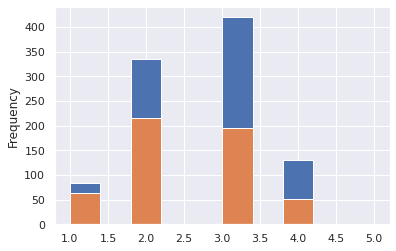

In [175]:
#we plot a histogram of sequence length
prefixSpan_result_df[prefixSpan_result_df.isPositive == True].seq_len.plot(kind='hist')
prefixSpan_result_df[prefixSpan_result_df.isPositive == False].seq_len.plot(kind='hist')

We consider that sequences of length one are not interesting and sequences of length 5 or more are too rare to be used. 

In [176]:
prefixSpan_result_df_middle_len = prefixSpan_result_df.loc[(prefixSpan_result_df.seq_len > 1) & (prefixSpan_result_df.seq_len < 5)]
prefixSpan_result_df_middle_len.frequency.describe()

count    1349.000000
mean     2490.063010
std      542.779556 
min      2000.000000
25%      2126.000000
50%      2299.000000
75%      2663.000000
max      5596.000000
Name: frequency, dtype: float64

The frequency distribution of frequent patterns is the same whether the review is positive or negative :

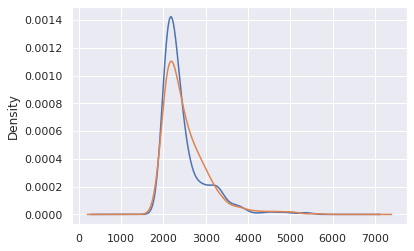

In [177]:
prefixSpan_result_df_middle_len[prefixSpan_result_df_middle_len.isPositive == True].frequency.plot(kind='kde')
prefixSpan_result_df_middle_len[prefixSpan_result_df_middle_len.isPositive == False].frequency.plot(kind='kde')

From all the above tests, we cannot infer any difference between positive and negative reviews by relying solely on prefixSpan output.

In the next section, we will do the same analysis on emergingPatterns.

## EmergingPatterns on prefixSpan output

Filter the emerging patterns of the positive reviews as compared to the negative reviews. 
You can test several minsup values and you can use constraints as a post-processing step, for example (i.e., length constraints, gap constraints...).

We do the emerging positive and negative patterns at the same time, then analyze positive patterns and answer questions.  
The negative patterns analysis is in a separate part.  

In [178]:
#we extract frequent patterns in an array for compatibility with emergingPatterns algorithm
pos_freq_patterns = list(prefixSpan_result_df_middle_len[prefixSpan_result_df_middle_len.isPositive == True].sequence)
neg_freq_patterns = list(prefixSpan_result_df_middle_len[prefixSpan_result_df_middle_len.isPositive == False].sequence)

#these two variables are our tokenized dataset
# whole_review_neg_tokenized_list
# whole_review_pos_tokenized_list

#we apply emerging patterns of positive and negative reviews on positive then negative datasets - start with a limit at 0
emerg_pos = emergingPatterns(pos_freq_patterns, whole_review_pos_tokenized_list, whole_review_neg_tokenized_list, 1)
emerg_pos[:5]

[([[("'s", "'s", 'PART')], [('I', '-PRON-', 'PRON')]], 1.0220720720720722),
 ([[("'s", "'s", 'PART')], [('is', 'be', 'AUX')]], 1.2215973003374578),
 ([[("'s", "'s", 'PART')], [('it', '-PRON-', 'PRON')]], 1.1537530266343825),
 ([[("'s", "'s", 'PART')], [('to', 'to', 'PART')]], 1.0962936046511629),
 ([[('/><br', '/><br', 'NUM')], [('is', 'be', 'AUX')]], 1.0291872474180512)]

In [179]:
emerg_neg = emergingPatterns(neg_freq_patterns, whole_review_neg_tokenized_list, whole_review_pos_tokenized_list, 1)
emerg_neg[:5]

[([[("'s", 'be', 'AUX')], [('I', '-PRON-', 'PRON')]], 1.2053973013493253),
 ([[("'s", 'be', 'AUX')], [('is', 'be', 'AUX')]], 1.0890516576715499),
 ([[("'s", 'be', 'AUX')], [('it', '-PRON-', 'PRON')]], 1.1101660591332523),
 ([[("'s", 'be', 'AUX')], [('to', 'to', 'PART')]], 1.1830227743271222),
 ([[('/><br', '/><br', 'NUM')], [('it', '-PRON-', 'PRON')]],
  1.0064070970921635)]

We check the pattern length distribution by forming a dataframe that contains all the patterns as well as their respective threshold, and a column "isPositive" with a boolean to indicate the review type :

In [180]:
emerg_df_pos = pd.DataFrame(emerg_pos, columns=['sequence', 'threshold'])
emerg_df_pos['isPositive'] = True

emerg_df_neg = pd.DataFrame(emerg_neg, columns=['sequence', 'threshold'])
emerg_df_neg['isPositive'] = False

emerg_df = pd.concat([emerg_df_pos, emerg_df_neg])
emerg_df.head()

,sequence,threshold,isPositive
0,"[[('s, 's, PART)], [(I, -PRON-, PRON)]]",1.022072,True
1,"[[('s, 's, PART)], [(is, be, AUX)]]",1.221597,True
2,"[[('s, 's, PART)], [(it, -PRON-, PRON)]]",1.153753,True
3,"[[('s, 's, PART)], [(to, to, PART)]]",1.096294,True
4,"[[(/><br, /><br, NUM)], [(is, be, AUX)]]",1.029187,True


Text(0.5, 1.0, 'Number of reviews per threshold value')

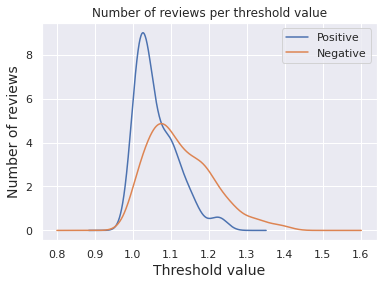

In [181]:
fig, ax = plt.subplots()

emerg_df[emerg_df.isPositive == True].threshold.plot(kind='kde', legend=True, ax=ax)
emerg_df[emerg_df.isPositive == False].threshold.plot(kind='kde', legend=True, ax=ax)
plt.xlabel('Threshold value', fontsize=14)
plt.ylabel('Number of reviews', fontsize=14)
ax.legend(["Positive", "Negative"])
plt.title('Number of reviews per threshold value')

This time, for an equal threshold, we can see a difference in the distribution of emergingPatterns between positive and negative reviews.  
Positive reviews seem to have a low standard deviation (less than 0.1) around growth rate 1.05, whereas negative reviews have a higher std (approx 0.2) around growth rate 1.1.  
This shift in std and growth rate center can allow the identification of some reviews if they have a very low or very high growth rate. If the review is located somewhere between 1.1 and 1.3, it becomes harder to judge on one element alone. A corpus of reviews is easier to classifiy.

## Positive patterns analysis

### How many emerging positive patterns ?

How many patterns do you have ? Write here the 10 most occurring positive emerging patterns as well as the ones you find the most interesting. 

In [182]:
print('Total number of patterns : ' +str(len(emerg_df)))
print('Number of positive patterns : ' +str(len(emerg_df[emerg_df.isPositive == True])))

Total number of patterns : 419
Number of positive patterns : 116


### Top 10 positive emerging patterns

Top 10 patterns by growth rate for positive reviews : 

In [183]:
emerg_df[emerg_df.isPositive == True].sort_values('threshold', ascending=False, ignore_index=True).head(10)

,sequence,threshold,isPositive
0,"[[(as, as, SCONJ)], [(as, as, SCONJ)]]",1.234288,True
1,"[[(is, be, AUX)], [(as, as, SCONJ)], [(is, be, AUX)]]",1.233099,True
2,"[[('s, 's, PART)], [(is, be, AUX)]]",1.221597,True
3,"[[(is, be, AUX)], [(is, be, AUX)], [(as, as, SCONJ)]]",1.209130,True
4,"[[(is, be, AUX)], [('s, 's, PART)]]",1.174220,True
5,"[[(is, be, AUX)], [(as, as, SCONJ)], [(it, -PRON-, PRON)]]",1.169532,True
6,"[[(is, be, AUX)], [(as, as, SCONJ)]]",1.158403,True
7,"[[(as, as, SCONJ)], [(is, be, AUX)], [(is, be, AUX)]]",1.155955,True
8,"[[('s, 's, PART)], [(it, -PRON-, PRON)]]",1.153753,True
9,"[[(has, have, AUX)], [(it, -PRON-, PRON)]]",1.151273,True


Top 10 "most interesting" patterns in positive reviews :

In [184]:
#first we create a specific POS detection function
def is_pos_in_seq(search_pos, seq):

  for token in seq:
    if search_pos in token[0]:
      return True

  return False

#test
is_pos_in_seq('PART', [[("'s", "'s", 'PART')], [("'s", "'s", 'PART')]])

True

In [185]:
#then we apply it to the result dataframe
emerg_df['hasNOUN'] = emerg_df.apply(lambda row: is_pos_in_seq('NOUN', row['sequence']), axis=1)

#and we filter by patterns containing a NOUN (and positive reviews), then sort by threshold
emerg_df[(emerg_df.isPositive == True) & (emerg_df.hasNOUN == True)].sort_values('threshold', ascending=False, ignore_index=True).head(10)

,sequence,threshold,isPositive,hasNOUN
0,"[[(is, be, AUX)], [(is, be, AUX)], [(film, film, NOUN)]]",1.107498,True,True
1,"[[(is, be, AUX)], [(film, film, NOUN)], [(is, be, AUX)]]",1.102790,True,True
2,"[[(film, film, NOUN)], [(film, film, NOUN)]]",1.099425,True,True
3,"[[(film, film, NOUN)], [(is, be, AUX)], [(is, be, AUX)]]",1.087704,True,True
4,"[[(is, be, AUX)], [(film, film, NOUN)]]",1.079933,True,True
5,"[[(film, film, NOUN)], [(is, be, AUX)]]",1.066860,True,True
6,"[[(film, film, NOUN)], [(is, be, AUX)], [(it, -PRON-, PRON)]]",1.058738,True,True
7,"[[(is, be, AUX)], [(to, to, PART)], [(film, film, NOUN)]]",1.037161,True,True
8,"[[(to, to, PART)], [(is, be, AUX)], [(film, film, NOUN)]]",1.020823,True,True
9,"[[(film, film, NOUN)], [(it, -PRON-, PRON)]]",1.018101,True,True


We can see that most patterns containing a NOUN POS attribute have either the word "film" or "time", followed by an AUX like is. This shows that the text content is about the describtion of movies.  
About the "time" (time is, time to, time it) could either refer to the timing of movies ("the director takes the time to describe..."), to film sequels or subsequent movies from a same director ("this time it talks about...")  

Below are a few counts of the patterns in the original corpus (we filtered a lot of POS types to build these patterns and cannot look for a pattern like "film", "film", "film" because it contains these filtered out words in-between).

In [186]:
#find some patterns about time in the raw corpus :
def number_of_reviews_containing_filter(filter_search, df):
  print('Numer of reviews containing : \"'+filter_search+'\" : '+str(len(df[train_pos_df.content.str.contains(filter_search)])))

number_of_reviews_containing_filter('time is', train_pos_df)
number_of_reviews_containing_filter('time to', train_pos_df)
number_of_reviews_containing_filter('time it', train_pos_df)

number_of_reviews_containing_filter('film it', train_pos_df)
number_of_reviews_containing_filter('\'s film', train_pos_df)

Numer of reviews containing : "time is" : 36
Numer of reviews containing : "time to" : 190
Numer of reviews containing : "time it" : 74
Numer of reviews containing : "film it" : 81
Numer of reviews containing : "'s film" : 127


## Negative Patterns

### How many emerging negative patterns ?

Filter the emerging patterns of the negative reviews as compared to the positive reviews. 
You can test several minsup values and you can use constraints as a post-processing step, for example (i.e., length constraints, gap constraints...).

How many patterns do you have ? Write here the 10 most occurring negative emerging patterns as well as the ones you find the most interesting. 

In [187]:
print('Total number of patterns : ' +str(len(emerg_df)))
print('Number of negative patterns : ' +str(len(emerg_df[emerg_df.isPositive == False])))

Total number of patterns : 419
Number of negative patterns : 303


We sort the emerging patterns of negative reviews. We find that the top patterns already contain a NOUN without the need for additional filtering.

In [188]:
emerg_df[emerg_df.isPositive == False].sort_values('threshold', ascending=False, ignore_index=True).head(10)

,sequence,threshold,isPositive,hasNOUN
0,"[[(was, be, AUX)], [(n't, not, PART)]]",1.401301,False,False
1,"[[(to, to, PART)], [(n't, not, PART)]]",1.389703,False,False
2,"[[(I, -PRON-, PRON)], [(n't, not, PART)]]",1.385343,False,False
3,"[[(n't, not, PART)], [(to, to, PART)]]",1.382092,False,False
4,"[[(movie, movie, NOUN)], [(to, to, PART)]]",1.354782,False,True
5,"[[(n't, not, PART)], [(I, -PRON-, PRON)]]",1.345525,False,False
6,"[[(it, -PRON-, PRON)], [(n't, not, PART)]]",1.338235,False,False
7,"[[(movie, movie, NOUN)], [(is, be, AUX)], [(to, to, PART)]]",1.324701,False,True
8,"[[(I, -PRON-, PRON)], [(movie, movie, NOUN)]]",1.323984,False,True
9,"[[(to, to, PART)], [(movie, movie, NOUN)]]",1.323824,False,True


This time, the term "film" has been replaced by "movie". Cound this mean that most people writing negative reviews refer to the described material as a movie, and most people writing positive reviews refer to the material as "film" ?

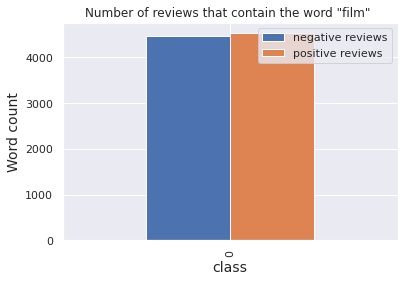

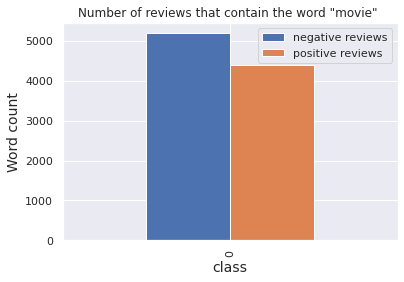

In [189]:
fig, ax = plt.subplots()
pd.DataFrame([[train_neg_df.content.str.contains('film').sum(), train_pos_df.content.str.contains('film').sum()]], columns=['negative reviews', 'positive reviews']).plot(kind='bar', ax=ax)
plt.xlabel('class', fontsize=14)
plt.ylabel('Word count', fontsize=14)
plt.title('Number of reviews that contain the word \"film\" ')
plt.show()

fig, ax = plt.subplots()
pd.DataFrame([[train_neg_df.content.str.contains('movie').sum(), train_pos_df.content.str.contains('movie').sum()]], columns=['negative reviews', 'positive reviews']).plot(kind='bar', ax=ax)
plt.xlabel('class', fontsize=14)
plt.ylabel('Word count', fontsize=14)
plt.title('Number of reviews that contain the word \"movie\" ')
plt.show()


From the above graphs we can see that the word film is used as often in positive or negative reviews.  
However, the negative reviews have 20% more "movie" usage than the positive ones.  
I looked online and couldn't find a simple explanation (the word movie is not pejorative, or less respectful than the word movie). 

When looking at Google Trends ( https://trends.google.com/trends/explore?date=all&q=movie,film ), it seems to be a regional issue :



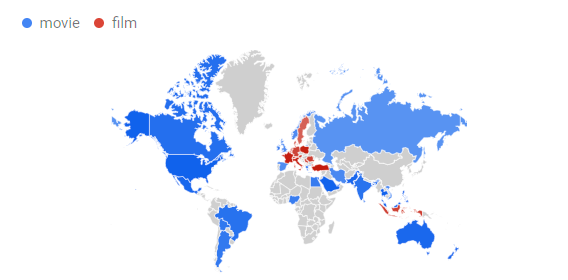

## Closed patterns

Do the same but using closed patterns instead of frequent sequential patterns.

In [190]:
whole_review_neg_frequent_patterns_closed = copy.deepcopy(whole_review_neg_frequent_patterns)
whole_review_pos_frequent_patterns_closed = copy.deepcopy(whole_review_pos_frequent_patterns)
filterClosed(whole_review_neg_frequent_patterns_closed)
filterClosed(whole_review_pos_frequent_patterns_closed)

We merge all our data into a unique Dataframe containing the sequences, associated frequency, and a column "isPositive" to indicate whether the review is positive or negative :

In [191]:
whole_review_pos_frequent_patterns_closed_df = pd.DataFrame(whole_review_pos_frequent_patterns_closed, columns=['sequence', 'frequency'])
whole_review_pos_frequent_patterns_closed_df['isPositive'] = True

whole_review_neg_frequent_patterns_closed_df = pd.DataFrame(whole_review_neg_frequent_patterns_closed, columns=['sequence', 'frequency'])
whole_review_neg_frequent_patterns_closed_df['isPositive'] = False

patterns_closed_df = pd.concat([whole_review_pos_frequent_patterns_closed_df, whole_review_neg_frequent_patterns_closed_df])
patterns_closed_df.head()

,sequence,frequency,isPositive
0,"[[('s, 's, PART)]]",3611,True
1,"[[('s, 's, PART)], [(I, -PRON-, PRON)]]",2220,True
2,"[[('s, 's, PART)], [(is, be, AUX)]]",2667,True
3,"[[('s, 's, PART)], [(it, -PRON-, PRON)]]",2478,True
4,"[[('s, 's, PART)], [(to, to, PART)]]",2752,True


Closed patterns do not have a different frequency repartition contrary to frequent patterns :

Text(0.5, 1.0, 'Number of reviews per frequency')

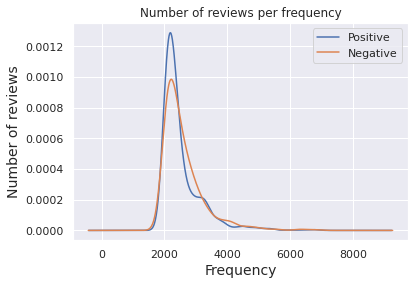

In [192]:
fig, ax = plt.subplots()

patterns_closed_df[patterns_closed_df.isPositive == True].frequency.plot(kind='kde', legend=True, ax=ax)
patterns_closed_df[patterns_closed_df.isPositive == False].frequency.plot(kind='kde', legend=True, ax=ax)
plt.xlabel('Frequency', fontsize=14)
plt.ylabel('Number of reviews', fontsize=14)
ax.legend(["Positive", "Negative"])
plt.title('Number of reviews per frequency')

### Positive reviews : closed patterns

How many patterns do you have ? Write here the 10 most occurring positive emerging patterns as well as the ones you find the most interesting. 

Number of positive closed patterns :

In [193]:
print('Total number of patterns : ' +str(len(patterns_closed_df)))
print('Number of positive patterns : ' +str(len(patterns_closed_df[patterns_closed_df.isPositive == True])))

Total number of patterns : 1497
Number of positive patterns : 969


Top 10 positive patterns by frequency :

In [194]:
patterns_closed_df[patterns_closed_df.isPositive == True].sort_values('frequency', ascending=False, ignore_index=True).head(10)

,sequence,frequency,isPositive
0,"[[(to, to, PART)]]",6823,True
1,"[[(is, be, AUX)]]",6684,True
2,"[[(it, -PRON-, PRON)]]",6368,True
3,"[[(I, -PRON-, PRON)]]",5922,True
4,"[[(to, to, PART)], [(to, to, PART)]]",5416,True
5,"[[(is, be, AUX)], [(is, be, AUX)]]",5393,True
6,"[[(is, be, AUX)], [(to, to, PART)]]",5345,True
7,"[[(to, to, PART)], [(is, be, AUX)]]",5283,True
8,"[[(was, be, AUX)]]",5206,True
9,"[[(to, to, PART)], [(it, -PRON-, PRON)]]",5016,True


Interesting patterns :

In [195]:
patterns_closed_df['hasNOUN'] = patterns_closed_df.apply(lambda row: is_pos_in_seq('NOUN', row['sequence']), axis=1)
patterns_closed_df[(patterns_closed_df.isPositive == True) & (patterns_closed_df.hasNOUN == True)].sort_values('frequency', ascending=False, ignore_index=True).head(10)

,sequence,frequency,isPositive,hasNOUN
0,"[[(movie, movie, NOUN)]]",4896,True,True
1,"[[(film, film, NOUN)]]",4047,True,True
2,"[[(movie, movie, NOUN)], [(to, to, PART)]]",3853,True,True
3,"[[(movie, movie, NOUN)], [(is, be, AUX)]]",3762,True,True
4,"[[(movie, movie, NOUN)], [(it, -PRON-, PRON)]]",3676,True,True
5,"[[(to, to, PART)], [(movie, movie, NOUN)]]",3573,True,True
6,"[[(is, be, AUX)], [(movie, movie, NOUN)]]",3510,True,True
7,"[[(movie, movie, NOUN)], [(I, -PRON-, PRON)]]",3374,True,True
8,"[[(movie, movie, NOUN)], [(movie, movie, NOUN)]]",3289,True,True
9,"[[(it, -PRON-, PRON)], [(movie, movie, NOUN)]]",3283,True,True


Most top 10 patterns that contain a NOUN POS have the word "movie". These are all positive reviews, so our previous analysis (movie = bad review) doesn't hold when looking at closed patterns.  

### Negative reviews : closed patterns

How many patterns do you have ? Write here the 10 most occurring negative emerging patterns as well as the ones you find the most interesting. 

In [196]:
print('Total number of patterns : ' +str(len(patterns_closed_df)))
print('Number of negative patterns : ' +str(len(patterns_closed_df[patterns_closed_df.isPositive == False])))

Total number of patterns : 1497
Number of negative patterns : 528


Top negative closed patterns :

In [197]:
patterns_closed_df[patterns_closed_df.isPositive == False].sort_values('frequency', ascending=False, ignore_index=True).head(10)

,sequence,frequency,isPositive,hasNOUN
0,"[[(is, be, AUX)]]",6844,False,False
1,"[[(to, to, PART)]]",6426,False,False
2,"[[(it, -PRON-, PRON)]]",6250,False,False
3,"[[(is, be, AUX)], [(is, be, AUX)]]",5596,False,False
4,"[[(I, -PRON-, PRON)]]",5464,False,False
5,"[[(is, be, AUX)], [(to, to, PART)]]",5095,False,False
6,"[[(is, be, AUX)], [(it, -PRON-, PRON)]]",5043,False,False
7,"[[(to, to, PART)], [(is, be, AUX)]]",5025,False,False
8,"[[(it, -PRON-, PRON)], [(is, be, AUX)]]",4761,False,False
9,"[[(as, as, SCONJ)]]",4750,False,False


Interesting patterns :

In [198]:
patterns_closed_df['hasNOUN'] = patterns_closed_df.apply(lambda row: is_pos_in_seq('NOUN', row['sequence']), axis=1)
patterns_closed_df[(patterns_closed_df.isPositive == False) & (patterns_closed_df.hasNOUN == True)].sort_values('frequency', ascending=False, ignore_index=True).head(10)

,sequence,frequency,isPositive,hasNOUN
0,"[[(film, film, NOUN)]]",4179,False,True
1,"[[(movie, movie, NOUN)]]",4072,False,True
2,"[[(film, film, NOUN)], [(is, be, AUX)]]",3303,False,True
3,"[[(is, be, AUX)], [(film, film, NOUN)]]",3229,False,True
4,"[[(movie, movie, NOUN)], [(is, be, AUX)]]",3118,False,True
5,"[[(film, film, NOUN)], [(to, to, PART)]]",3006,False,True
6,"[[(is, be, AUX)], [(movie, movie, NOUN)]]",2989,False,True
7,"[[(film, film, NOUN)], [(it, -PRON-, PRON)]]",2981,False,True
8,"[[(to, to, PART)], [(film, film, NOUN)]]",2949,False,True
9,"[[(movie, movie, NOUN)], [(it, -PRON-, PRON)]]",2942,False,True


We cannot infer much about these rules either : the top 2 words are yet again "movie" and "film".  

## Maximal patterns

Do the same but using maximal patterns instead of frequent sequential patterns.

In [199]:
whole_review_neg_frequent_patterns_max = copy.deepcopy(whole_review_neg_frequent_patterns)
whole_review_pos_frequent_patterns_max = copy.deepcopy(whole_review_pos_frequent_patterns)
filterMaximal(whole_review_neg_frequent_patterns_max)
filterMaximal(whole_review_pos_frequent_patterns_max)

Once again we merge all our data into a unique Dataframe containing the sequences, associated frequency, and a column "isPositive" to indicate whether the review is positive or negative :

In [200]:
whole_review_pos_frequent_patterns_max_df = pd.DataFrame(whole_review_pos_frequent_patterns_max, columns=['sequence', 'frequency'])
whole_review_pos_frequent_patterns_max_df['isPositive'] = True

whole_review_neg_frequent_patterns_max_df = pd.DataFrame(whole_review_neg_frequent_patterns_max, columns=['sequence', 'frequency'])
whole_review_neg_frequent_patterns_max_df['isPositive'] = False

patterns_max_df = pd.concat([whole_review_neg_frequent_patterns_max_df, whole_review_pos_frequent_patterns_max_df])
patterns_max_df.head()

,sequence,frequency,isPositive
0,"[[('s, 's, PART), (is, be, AUX)]]",2213,False
1,"[[('s, 's, PART)], [('s, 's, PART)]]",2187,False
2,"[[('s, 's, PART)], [(I, -PRON-, PRON)]]",2269,False
3,"[[('s, 's, PART)], [(as, as, SCONJ)]]",2270,False
4,"[[('s, 's, PART)], [(is, be, AUX)], [(is, be, AUX)]]",2398,False


For maximal patterns, we cannot see any frequency repartition difference :

Text(0.5, 1.0, 'Number of reviews per frequency')

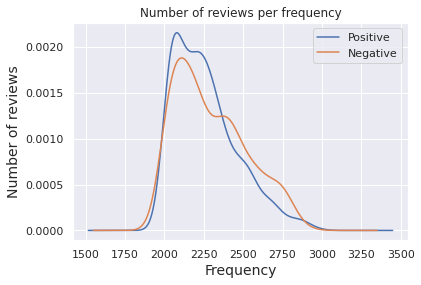

In [201]:
fig, ax = plt.subplots()

patterns_max_df[patterns_max_df.isPositive == True].frequency.plot(kind='kde', legend=True, ax=ax)
patterns_max_df[patterns_max_df.isPositive == False].frequency.plot(kind='kde', legend=True, ax=ax)
plt.xlabel('Frequency', fontsize=14)
plt.ylabel('Number of reviews', fontsize=14)
ax.legend(["Positive", "Negative"])
plt.title('Number of reviews per frequency')

### Positive reviews : maximal patterns

How many patterns do you have ? Write here the 10 most occurring negative emerging patterns as well as the ones you find the most interesting. 

In [202]:
print('Total number of patterns : ' +str(len(patterns_max_df)))
print('Number of positive patterns : ' +str(len(patterns_max_df[patterns_max_df.isPositive == True])))

Total number of patterns : 1159
Number of positive patterns : 769


Top negative closed patterns :

In [203]:
patterns_max_df[patterns_max_df.isPositive == True].sort_values('frequency', ascending=False, ignore_index=True).head(10)

,sequence,frequency,isPositive
0,"[[(to, to, PART)], [(it, -PRON-, PRON)], [(I, -PRON-, PRON)]]",2966,True
1,"[[(is, be, AUX)], [(it, -PRON-, PRON)], [(I, -PRON-, PRON)]]",2939,True
2,"[[(to, to, PART)], [(I, -PRON-, PRON)], [(it, -PRON-, PRON)]]",2903,True
3,"[[(it, -PRON-, PRON)], [(is, be, AUX)], [(I, -PRON-, PRON)]]",2881,True
4,"[[(it, -PRON-, PRON)], [(it, -PRON-, PRON)], [(I, -PRON-, PRON)]]",2879,True
5,"[[(to, to, PART)], [(I, -PRON-, PRON)], [(is, be, AUX)]]",2878,True
6,"[[(was, be, AUX)], [(to, to, PART)], [(to, to, PART)]]",2871,True
7,"[[(is, be, AUX)], [(I, -PRON-, PRON)], [(is, be, AUX)]]",2859,True
8,"[[(it, -PRON-, PRON)], [(I, -PRON-, PRON)], [(to, to, PART)]]",2859,True
9,"[[(is, be, AUX)], [(I, -PRON-, PRON)], [(I, -PRON-, PRON)]]",2857,True


Interesting patterns :

In [204]:
patterns_max_df['hasNOUN'] = patterns_max_df.apply(lambda row: is_pos_in_seq('NOUN', row['sequence']), axis=1)
patterns_max_df[(patterns_max_df.isPositive == True) & (patterns_max_df.hasNOUN == True)].sort_values('frequency', ascending=False, ignore_index=True).head(10)

,sequence,frequency,isPositive,hasNOUN
0,"[[(was, be, AUX)], [(movie, movie, NOUN)]]",2801,True,True
1,"[[(it, -PRON-, PRON)], [(film, film, NOUN)]]",2724,True,True
2,"[[(movie, movie, NOUN)], [(is, be, AUX)], [(is, be, AUX)]]",2693,True,True
3,"[[(movie, movie, NOUN)], [(to, to, PART)], [(to, to, PART)]]",2689,True,True
4,"[[(movie, movie, NOUN)], [(is, be, AUX)], [(to, to, PART)]]",2660,True,True
5,"[[(movie, movie, NOUN)], [(to, to, PART)], [(is, be, AUX)]]",2601,True,True
6,"[[(I, -PRON-, PRON)], [(film, film, NOUN)]]",2587,True,True
7,"[[(movie, movie, NOUN)], [(to, to, PART)], [(it, -PRON-, PRON)]]",2565,True,True
8,"[[(film, film, NOUN)], [(I, -PRON-, PRON)]]",2560,True,True
9,"[[(time, time, NOUN)]]",2533,True,True


We observe longuer sequences (length is never below 3) with lower frequencies and a low fred std (range is under 10%).  
The obtained NOUNs are yet again "movie" and "film", which are the most common nouns amongst the review corpus.

### Negative reviews : maximal patterns

How many patterns do you have ? Write here the 10 most occurring negative emerging patterns as well as the ones you find the most interesting. 

In [205]:
print('Total number of patterns : ' +str(len(patterns_max_df)))
print('Number of negative patterns : ' +str(len(patterns_max_df[patterns_max_df.isPositive == False])))

Total number of patterns : 1159
Number of negative patterns : 390


Top negative closed patterns :

In [206]:
patterns_max_df[patterns_max_df.isPositive == False].sort_values('frequency', ascending=False, ignore_index=True).head(10)

,sequence,frequency,isPositive,hasNOUN
0,"[[(it, -PRON-, PRON)], [(to, to, PART)], [(to, to, PART)]]",2900,False,False
1,"[[(to, to, PART)], [(it, -PRON-, PRON)], [(to, to, PART)]]",2827,False,False
2,"[[(it, -PRON-, PRON)], [(it, -PRON-, PRON)], [(to, to, PART)]]",2826,False,False
3,"[[(was, be, AUX)], [(was, be, AUX)]]",2825,False,False
4,"[[(to, to, PART)], [(have, have, AUX)]]",2803,False,False
5,"[[(I, -PRON-, PRON)], [(it, -PRON-, PRON)], [(it, -PRON-, PRON)]]",2802,False,False
6,"[[(to, to, PART)], [(n't, not, PART)]]",2797,False,False
7,"[[(I, -PRON-, PRON)], [(I, -PRON-, PRON)], [(I, -PRON-, PRON)]]",2783,False,False
8,"[[(is, be, AUX)], [(is, be, AUX)], [(is, be, AUX)], [(it, -PRON-, PRON)]]",2771,False,False
9,"[[(I, -PRON-, PRON)], [(as, as, SCONJ)]]",2770,False,False


Interesting patterns :

In [207]:
patterns_max_df['hasNOUN'] = patterns_max_df.apply(lambda row: is_pos_in_seq('NOUN', row['sequence']), axis=1)
patterns_max_df[(patterns_max_df.isPositive == False) & (patterns_max_df.hasNOUN == True)].sort_values('frequency', ascending=False, ignore_index=True).head(10)

,sequence,frequency,isPositive,hasNOUN
0,"[[(to, to, PART)], [(movie, movie, NOUN)]]",2699,False,True
1,"[[(it, -PRON-, PRON)], [(movie, movie, NOUN)]]",2614,False,True
2,"[[(movie, movie, NOUN)], [(I, -PRON-, PRON)]]",2566,False,True
3,"[[(time, time, NOUN)]]",2550,False,True
4,"[[(movie, movie, NOUN)], [(movie, movie, NOUN)]]",2505,False,True
5,"[[(film, film, NOUN)], [(is, be, AUX)], [(is, be, AUX)]]",2468,False,True
6,"[[(I, -PRON-, PRON)], [(movie, movie, NOUN)]]",2460,False,True
7,"[[(is, be, AUX)], [(is, be, AUX)], [(film, film, NOUN)]]",2452,False,True
8,"[[(story, story, NOUN)]]",2426,False,True
9,"[[(film, film, NOUN)], [(I, -PRON-, PRON)]]",2425,False,True


The conclusion is the same as the maximal patterns on positive reviews : low std of frequency, high sequence length, the only nouns are "movie" and "film".